# _SentimentAnalyzer_ - Automatic Analysis of News Articles with Google Cloud Natural Language API


## Background

Reputational due diligence is a process of analyzing the reputation of an entity (either a person or an organization) and identifying any reputational risks associated with the entity. Traditionally, it is performed through a manual review and analysis of documents (e.g. news articles, legal documents and specialized publications) in which the entity of interest is mentioned. Such a manual process is cumbersome and time consuming.

We hereby present a solution, called _SentimentAnalyzer_, that automates the sentiment analysis of news articles. It can accept a collection of news articles and perform the following analysis on each article:
- measure its overall sentiment 
- extract all the noteworthy individuals mentioned in the article
- measure the sentiment of these individuals

The script then uploads the analysis results into a BigQuery table, which is in turn connected to a Data Studio dashboard that visualizes these results. 

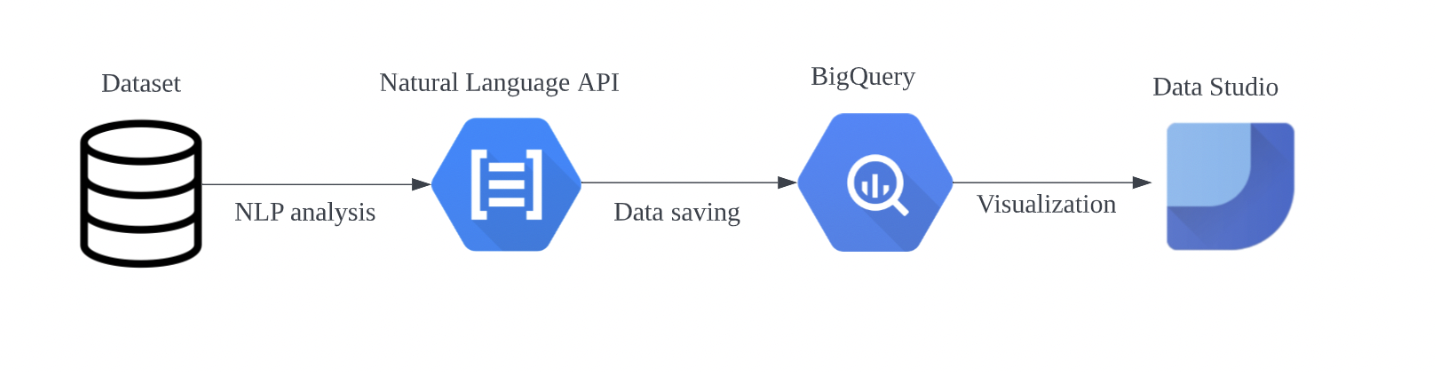

# Project Structure

This notebook contains the following steps:
- The creation of BigQuery table that will store the articles and the analysis results
- The import, description and EDA of the dataset
- The application of the core function `analyze_article` that applies the Natural Language API and performs sentiment analysis on a given article
- The uploading of the analysis results on the BigQuery table

Should you want to run the above steps from scratch, please run the notebook from top to bottom after you've installed the dependencies listed in `requirements.txt`.

The accompanying Data Studio dashboard, which visualizes the analysis results, can be found on the following [link](https://datastudio.google.com/u/0/reporting/9f62a4aa-3b5f-4716-b190-10be9a2b9bb2/page/0weuC). 

## Imports and Setup


In [2]:
%load_ext autoreload
%autoreload 2

import requests
import time
import numpy as np
import pandas as pd
from pprint import pprint
from google.cloud import bigquery
from functools import partial
import concurrent.futures
import multiprocessing
from tqdm import tqdm
import warnings

from utils import analyze_article, draw_boxplot_histogram

tqdm.pandas()
num_processes = multiprocessing.cpu_count()

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Project-Parameters

If you want to run this notebook outside of its original development environment, please modify the following project-level parameters.

In [1]:
PROJECT = "aliz-ml-spec-2022-dev"
DATASET = "ml_specialization"
TABLE = "articles"

# Table Creation

In this section, a BigQuery dataset called `ml_specialization` will be created. Within this dataset, a table called `articles` will be created. This table will store the article details and analysis results. 

In [19]:
# Create dataset
bq_client = bigquery.Client()
bq_client.create_dataset(DATASET, exists_ok = True)
dataset_ref = bigquery.DatasetReference(PROJECT, DATASET)

# create date-partitioned table
SCHEMA = [
    bigquery.SchemaField("insert_datetime", "DATETIME", mode="NULLABLE"),
    bigquery.SchemaField("publish_date", "DATE", mode="NULLABLE"),
    bigquery.SchemaField("title", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("article_source_link", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("article_sentiment", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("persons", "RECORD", mode="REPEATED",
        fields=[
            bigquery.SchemaField("name", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("wikipedia_uri", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("num_sentences", "INT64", mode="NULLABLE"),
            bigquery.SchemaField("person_sentiment", "FLOAT", mode="NULLABLE"),
            ])]
DESCRIPTION = "This table stores the articles and their details, including the results from Natural Language API" 
                         
table_ref = dataset_ref.table(TABLE)
table = bigquery.Table(table_ref, schema=SCHEMA)
table.description=DESCRIPTION
# partitioning
table.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field="publish_date",  
) 

try:
    table = bq_client.create_table(table, exists_ok = False)  
    print("Created table `{}`".format(table.full_table_id))
    
except:
    print(f"Note: table `{PROJECT}.{DATASET}.{TABLE}` already exists!")

Note: table `aliz-ml-spec-2022-dev.ml_specialization.articles` already exists!


# Dataset

The dataset we used, “News Articles”, was made available by Harvard Dataverse, a repository for research data from Harvard University. The dataset is publicly available with no copyright or restriction to its use. A copy of the dataset is available at the following GCS URI: `gs://harvard_news_dataset/NewsArticles.csv` 

The dataset contains details about ~3,800 English language news articles, including their publication dates, titles, and textual contents. These articles were published between December 2016 and March 2017 by major news outlets such as ABC News, CNN news, BBC News and Al Jazeera News.

For our solution, only the following four columns will be used:
- `publish_date`: the original publication date of the article
- `article_source_link`: the URL of the news article
- `title`: the title of the article
- `text`: the textual content of the article

Because the dataset already presents the data (i.e. the articles) in the correct format for downstream analysis, no feature engineering or preprocessing step is done. The only pre-analysis step we did was to remove the rows with missing `text`, of which there was only 33. 

In [9]:
article_df = pd.read_csv("NewsArticles.csv", encoding='unicode_escape', usecols=["publish_date", "article_source_link", "title", "text"])
article_df.isna().sum()

publish_date           0 
article_source_link    0 
title                  60
text                   33
dtype: int64

In [4]:
article_df.dropna(axis=0, subset =["text"], inplace=True)

In [4]:
article_df.head(1)

,publish_date,article_source_link,title,text
0,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie-betsy-devos-confirmation-vote-today/story?id=45310061,"Betsy DeVos Confirmed as Education Secretary, With Pence Casting Historic Tie-Breaking Vote","Michigan billionaire education activist Betsy DeVos was confirmed today to serve as the secretary of education in President Trump's administration, after Vice President Mike Pence cast a tie-breaking vote in the Senate. The Senate voted on DeVos""?highly contentious nomination this afternoon, and the tally was split evenly, requiring Pence to use his authority as president of the upper chamber of Congress to break the impasse. This was the first time that a vice president has broken a tie to confirm a Cabinet nominee. Pence read the vote count 50-50 and then voted himself, rendering the tally 51-50. The day before the vote, Democrats staged a 24-hour marathon of speeches, with more than 30 lawmakers taking to the floor to urge at least one additional Republican to vote against DeVos and block her confirmation. ""It is hard to imagine a worse choice,""?Sen. Elizabeth Warren, D-Mass., said before she read letters from constituents urging her to vote no. DeVos stirred up vehement opposition from teachers""?unions and all 48 Senate Democrats. Many cited concerns about her support of school vouchers, which critics believe will weaken public schools, and her lack of experience, since she never attended or worked in the public education system. Others cited her lack of familiarity with a landmark law protecting the education needs of disabled children. She was panned for a gaffe during her confirmation hearing, when she hedged on an answer about guns in schools by saying they might be needed in states like Wyoming to defend against ""potential grizzlies.""?DeVos' nomination drew above-average negative reactions from the public, with voters flooding Senate phone lines and email accounts in recent weeks. Sen. Chris Van Hollen, D-Md., said his office received 14,000 calls about DeVos. In addition to the entire Democratic caucus, two moderate Republicans, Sens. Susan Collins of Maine and Lisa Murkowski of Alaska announced they would not support DeVos. During a speech announcing her opposition, Collins said DeVos""?focus on charters and vouchers ""raises the question of whether or not she fully appreciates that the secretary of education's primary focus must be on helping states and communities, parents, teachers, school board members and administrators strengthen our public schools.""?Before the confirmation vote, the Senate Health, Education, Labor and Pensions Committee voted along party lines, 12-11, to refer DeVos""?nomination to the full Senate. ABC News""?Morgan Winsor contributed to this report."


# Analyse the Content Using Cloud Natural Language API


We will subject each article’s textual content to the function `analyze_article`, which constitutes the core of our solution. 

This function makes a call to GCP’s Natural Language API and performs the following analysis on each article it is applied to:
- Measure the article’s overall sentiment. This sentiment value ranges from -1 (very negative) to +1 (very positive).
- Extract all the noteworthy individuals mentioned in the article (we used the existence of a personal Wikipedia page as a proxy of the individuals' noteworthiness).
- Measure the sentiment of the sentences in the article in which each individual is mentioned, as well as an average of these sentence-level sentiment scores. As before, this individual-level sentiment ranges from -1 to +1.

### Example 1

To illustrate the functioning of analyze_article, consider the following sports article from CNN. The article, entitled “St. Moritz 2017: Lindsey Vonn, Mikaela Shiffrin seek world titles”  is a part of the Harvard dataset. The article’s textual content has been assigned to a string variable `sample_text`:

In [5]:
NO = 40
sample_text = article_df["text"][NO]
sample_text_link = article_df['article_source_link'][NO]
print(f"sample_text (from {sample_text_link}):")
print("-"*100)
print(sample_text)

sample_text (from http://www.cnn.com/2017/02/07/sport/ski-world-championships-st-moritz-lindsey-vonn/index.html):
----------------------------------------------------------------------------------------------------
It's a chilling prospect and it's just the beginning of the men's downhill course in St. Moritz. The start hut is cut into a rock face and the slick slope is so steep -- 100% or 45 degrees -- TV cameramen must abseil into positions wearing crampons. But the one skier able to conquer their fear and harness this breakneck speed will be crowned world downhill champion for the next two years. The race is the highlight of the 2017 World Championships, which start this week in the chic Swiss town. St. Moritz, the jewel of the Engadin valley, has been a longtime destination for the jetset and draws a well-heeled international clientele to its fine-dining restaurants and five-star hotels.  Often dubbed the "home of winter sports," St. Moritz has hosted two Winter Olympics and four p

After passing sample_text as an argument to analyze_article, the function returns the article’s `article_sentiment` as well as `persons`, a list of dictionaries containing the noteworthy individuals mentioned in the article as well as their individual-specific sentiment, wikipedia URL and the number of sentences mentioning them. 

In [6]:
article_sentiment, persons = analyze_article(sample_text, postprocess=False)
print(f"Sentiment of this artice is {article_sentiment:.2f}")
print("Noteworthy individuals mentioned in the article are:")
pprint(persons[:4])

Sentiment of this artice is 0.10
Noteworthy individuals mentioned in the article are:
[{'name': 'Lindsey Vonn',
  'num_sentences': 2,
  'person_sentiment': 0.15000000596046448,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Lindsey_Vonn'},
 {'name': 'Mikaela Shiffrin',
  'num_sentences': 1,
  'person_sentiment': 0.20000000298023224,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Mikaela_Shiffrin'},
 {'name': 'Beat Feuz',
  'num_sentences': 1,
  'person_sentiment': 0.10000000149011612,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Beat_Feuz'},
 {'name': 'Anna Veith',
  'num_sentences': 1,
  'person_sentiment': -0.30000001192092896,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Anna_Veith'}]


### Example 2

The following is another example.

In [6]:
NO = 3
sample_text = article_df["text"][NO]
sample_text_link = article_df['article_source_link'][NO]
sample_text = article_df["text"][NO]
sample_text_link = article_df['article_source_link'][NO]
print(f"sample_text (from {sample_text_link}):")
print("-"*100)
print(sample_text)

sample_text (from http://abcnews.go.com/Politics/appeals-court-decide-challenge-trumps-immigration-executive-order/story?id=45325524):
----------------------------------------------------------------------------------------------------
This afternoon, three federal judges from the 9th Circuit Court of Appeals will hear oral arguments in the emergency legal challenge to President Trump's executive order that temporarily bars immigration and travel to the U.S. for people from seven Muslim-majority countries and for refugees. The hearing, which will be conducted over the phone at 3 p.m. Pacific time, will allow each side to give 30-minute arguments. The plaintiffs in this appeal, Washington and Minnesota, will state their case, as will the Department of Justice. The public can listen to the hearings live on the 9th Circuit website. The judges are expected to rule on the future of the executive order after hearing oral arguments. While their decision won't determine the constitutionality o

This second example illustrates two issues we faced when using the Natural Language API's entity recognition functionality as-is:
1. **Non-English Wikipedia URI**

We were not able to modify the language of the Wikipedia URIs returned by the API. For a reason unknown to us, 90% of the Wikipedia URIs returned are German ones. This seems to be an issue that is known in the community (there is an [open question](https://stackoverflow.com/questions/72210323/google-nlp-entities-returning-wikipedia-link-as-german-instead-of-english) about the issue in Stack Overflow). 


2. **A single entity appearing multiple times under different names** 

Another issue relates to the fact that some individuals appear multiple times under different names.For example, the former president has been referred to on different occasions as Donald J. Trump vs Donald Trump vs Trump (like for this example). Ideally, the solution should be able to recognize that these three entities refer to the same person.

In [7]:
article_sentiment, persons = analyze_article(sample_text, postprocess=False)
print(f"Sentiment of this artice is {article_sentiment:.2f}")
print("Noteworthy individuals mentioned in the article are:")
pprint(persons)

Sentiment of this artice is -0.30
Noteworthy individuals mentioned in the article are:
[{'name': 'Trump',
  'num_sentences': 7,
  'person_sentiment': -0.3857142903975078,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/Donald_Trump'},
 {'name': 'James Robart',
  'num_sentences': 1,
  'person_sentiment': -0.4000000059604645,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/James_Robart'},
 {'name': 'John Kelly',
  'num_sentences': 1,
  'person_sentiment': -0.30000001192092896,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/John_F._Kelly'},
 {'name': 'George W. Bush',
  'num_sentences': 1,
  'person_sentiment': -0.5,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/George_W._Bush'}]


We have embedded a functionality called `postprocess` in `analyze_article` to circumvent this issue. When activated, the `postprocess` argument calls a helper function that uses the HTML parser `BeautifulSoup` to extract the English Wikipedia-URI from the “other languages”  links originating from the original URI.


The above-mentioned  `postprocess` functionality allows us to unify these discrepant names. It does so based on the fact that all of them point to the same Wikipedia page (https://en.wikipedia.org/wiki/Donald_Trump). `postprocess` looks into this page and extracts its title (in this case, “Donald Trump”) and uses that to substitute the name originally returned by the Natural Language API.

However, this functionality requires the function to iterate through all Wikipedia URIs returned by the Natural Language API. Since a single article can be associated with many noteworthy people (thus many Wikipedia URIs), the activation of this functionality significantly slows down the function call. Hence, we decided not to use this functionality in bulk for our analysis.

Here, we demonstrate the way this functionality works for the second article example. Note how Trump's name is now standardized as "Donald Trump" - just like the title of his Wikipedia page. Also note how all the Wikipedia URLs are now in English. 

In [8]:
article_sentiment, persons = analyze_article(sample_text, postprocess=True)
print(f"Sentiment of this artice is {article_sentiment:.2f}")
print("Noteworthy individuals mentioned in the article are:")
pprint(persons)

Sentiment of this artice is -0.30
Noteworthy individuals mentioned in the article are:
[{'name': 'Donald Trump',
  'num_sentences': 7,
  'person_sentiment': -0.3857142903975078,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/Donald_Trump'},
 {'name': 'James Robart',
  'num_sentences': 1,
  'person_sentiment': -0.4000000059604645,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/James_Robart'},
 {'name': 'John F. Kelly',
  'num_sentences': 1,
  'person_sentiment': -0.30000001192092896,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/John_F._Kelly'},
 {'name': 'George W. Bush',
  'num_sentences': 1,
  'person_sentiment': -0.5,
  'wikipedia_uri': 'https://en.wikipedia.org/wiki/George_W._Bush'}]


# Application to all articles

Here, we apply `analyze_article` to all of the articles in the dataset. We used parallelization (multithreading) to speed up the process. 

In [47]:
# without parallelization
start = time.time()
# article_df['result'] = article_df["text"].progress_apply(lambda x: partial(analyze_article, postprocess = False)(x))
end = time.time()
print(end - start)

3805.6865348447


In [48]:
# with parallelization (multithreading)

start = time.time()
    
# Process the rows in chunks in parallel
with concurrent.futures.ThreadPoolExecutor(num_processes) as pool:
    article_df['result'] = list(tqdm(pool.map(partial(analyze_article, postprocess = False), article_df['text'], chunksize=10), total=article_df.shape[0])) 
    
end = time.time()
print(end - start)

100%|██████████| 3791/3791 [15:03<00:00,  4.20it/s]

903.4528577327728


In [49]:
article_df['article_sentiment'], article_df['persons'] = article_df["result"].str

# Analysis

In this section, we perform some further analysis on the dataset.

In [50]:
article_df["article_len"] = article_df["text"].apply(len)
article_df["num_persons"] = article_df["persons"].apply(len)

### Distribution of Number of Noteworthy Individuals

The graph below shows the distribution of the number of noteworthy individuals mentioned in the articles. We see that the distribution has an exponential decay shape with the median being 2 individuals.

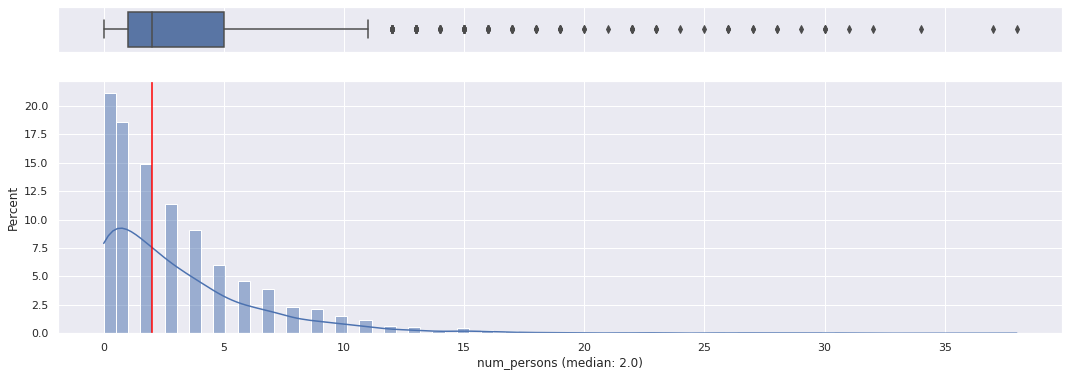

In [51]:
draw_boxplot_histogram(article_df, "num_persons")

## Distribution of article sentiment

The graph below shows the distribution of the sentiment values of the articles. We see that the median length of the sentiment is rather negative at -0.2. This is to be expected for news articles.

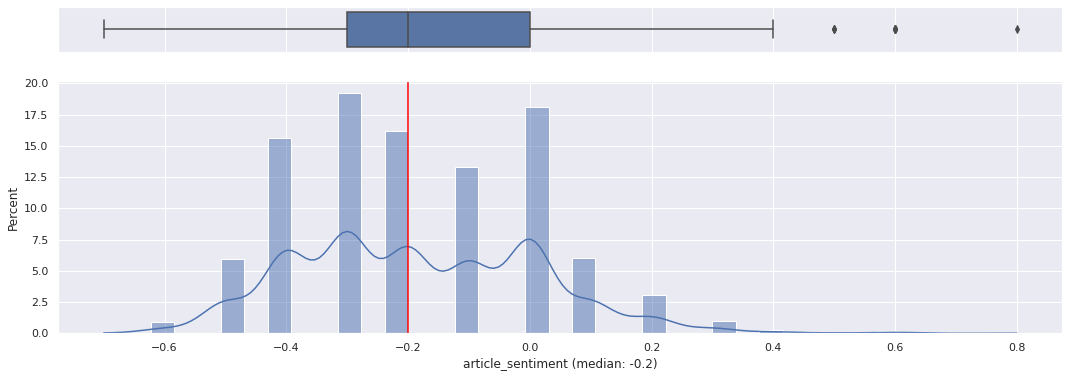

In [52]:
draw_boxplot_histogram(article_df, "article_sentiment")

## Distribution of article length

The graph below shows the distribution of article length, in character. We see that the median length of the articles is 2,718 characters.

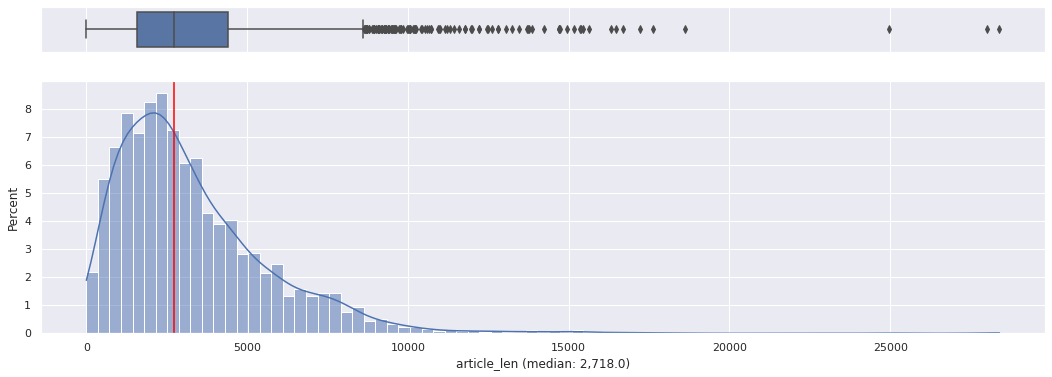

In [53]:
draw_boxplot_histogram(article_df, "article_len")

# Loading Results to BigQuery

The following code uploads our dataset, which already contain the NLP analysis results, onto the BigQuery table we created earlier. 

In [54]:
article_df["insert_datetime"] = pd.Timestamp.now()
article_df["publish_date"] = pd.to_datetime(article_df["publish_date"])

In [76]:
article_df = article_df[["insert_datetime", "publish_date", "title", "article_source_link", "article_sentiment", "persons"]]

In [82]:
job_config = bigquery.LoadJobConfig(
    schema=SCHEMA,
    write_disposition="WRITE_TRUNCATE",
)

job = bq_client.load_table_from_dataframe(
    article_df, "aliz-ml-spec-2022-dev.ml_specialization.articles", job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.


LoadJob<project=aliz-ml-spec-2022-dev, location=US, id=0e072a3b-91ba-484b-ae30-39c612104bc1>

In [83]:
job.done()

True